In [57]:
#Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid
import scipy as sc
import numpy as np
from numpy import random

from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn import preprocessing



from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings("always")

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
# import redes neuronales artificiales
from sklearn.neural_network import MLPClassifier
# import random forest
from sklearn.ensemble import RandomForestClassifier
# import maquinas de soporte vectorial
from sklearn.svm import SVC




## Análisis exploratorio de datos 

In [58]:
head_names = ['age', 'job', 'marital', 'education', 'credit', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y']
#df_bank = pd.read_csv('bank-full.csv', delimiter=';', header=None,names=head_names,skiprows=1)
df_bank = pd.read_csv('bank.csv', delimiter=';', header=None,names=head_names,skiprows=1)
print("Dimensión data set",df_bank.shape)
#df_bank.head()
y = df_bank["y"]
y = y.replace("no", 0)
y = y.replace("yes", 1)
X = df_bank.drop('y', axis=1)

Dimensión data set (4521, 17)


## Carácteristicas categóricas

En este caso se debe preprocesar aquellas carácteristicas categorical que el modelo no puede entender y convertirlas a variables númericas, a esto se le conoce como *"One Hot Encode"*. Se resuelve con la librería de sklearn o con pandas creando las variables ficticias conocidas **"Dummy variables"**.

Se debe tener en cuenta que podemos eliminar uno variable "dummy" porque si el resto de variables no son debe ser esa, esto quitará redundancia.

Este caso corresponde a las carácteristicas job,education,contact,month y las variables binarias como default, housing,loan, contact y  y.

In [59]:
#df_bank.dtypes

Se selecciona las variables tipo 'object', en este caso corresponde a variables categoricas. Esto nos permite separar dichas variables para su tratamiento con el "One Hot Encoding" segmentada. 

En la siguiente celda se observa que la variable mes puede ser reemplazado por un valor númerico directamente y así mismo con las variables binarias, a esto se le conoce como "Integer encoding"

In [60]:
obj_df = df_bank.select_dtypes(include=['object']).copy()
#obj_df.columns

#for column in obj_df.columns:
#    print(obj_df[column].value_counts(ascending=True))

In [61]:
# Reemplazar el mes y variables binarias por un valor numerico
cat_var = {'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12},
          'housing': {'yes':1,'no':0},
          'credit':{'yes':1,'no':0},
          'loan' : {'yes':1,'no':0},
          'y':{'yes':1,'no':0}
         }
obj_df.replace(cat_var, inplace=True)

#for i in range(df_bank.shape[0]):
#    df_bank.at[i, 'month'] = months[df_bank.at[i, 'month']]

In [62]:
#obj_df.head()

### One hot Encode job

Ahora bien, aún nos falta 5 variables por aplicar los valores númericos con más de 2 categorías. Tenemos 'job' con 12 categorías, 'marital' con 3, 'education' con 4, 'contact' con 3, por último 'poutcome' con 4.

Hay que tener en cuenta que existe una trampa de la variables ficticias creadas y consiste en crear una nueva variable por cada una, llega a ser redundante. Por tanto la solución está eliminar una de las variables categóricas, si hay $d$ número de categorías, use $d-1$ en el modelo, el valor omitido se puede considerar como el valor de referencia y los valores nuevos de las categorías restantes representan el cambio de esta referencia.

Dicho lo anterior se resta una categoría a cada variable y las otras 5 variables de categorías enteras esperamos 26 variables, el DataFrame resultante se guarda en **obj_df**

In [63]:
cols_dummies = ['job', 'marital', 'education', 'contact', 'poutcome']
obj_df = pd.get_dummies(obj_df,prefix=cols_dummies, drop_first=True)
#len(obj_df.columns)

In [64]:
#Nombre de las variables categoricas
cat_vars = cols_dummies + list(cat_var.keys())

Nos disponemos a concatenar las variables tipo enteras con las categóricas.

In [65]:
index = ['age','housing', 'loan', 'job_blue-collar','job_entrepreneur', 'job_housemaid', 'job_management', 
         'job_retired','job_self-employed', 'job_services', 'job_student', 'job_technician','job_unemployed',
         'job_unknown', 'marital_married', 'marital_single','education_secondary', 'education_tertiary', 
         'education_unknown','day', 'month','contact_telephone', 'contact_unknown',  'balance',  'duration', 
         'campaign', 'pdays', 'previous','credit','poutcome_other','poutcome_success', 'poutcome_unknown', 'y']

df_bank_copy = df_bank.copy()
df_bank_copy = df_bank_copy.drop(columns=cat_vars)
df_bank_copy.head()
df_bank_2 = pd.concat([obj_df.T, df_bank_copy.T]).T
df_bank_2 = df_bank_2[index]
X = df_bank_2[index]
y = df_bank_2['y']

## Missing data

En nuestro análisis exploratorio, debemos lidiar con los valores faltantes. Al parecer en nuestro caso no hay, sin embargo muchas veces esos valores pueden de diferente formas tales como 0, signos de interrogación o números negativos (según su interpretación). Es así que decidimos ir más allá.

In [66]:
#X.info()
#X.isna().sum()

## Imbalanced Classes 

Una vez ya tenemos las variables categoricas listas para entrenar, surge otra cuestión. Contamos con un dataset desbalanceado, la clase positiva (el usuario que se suscribió a la campaña) representa un 13% en comparación de la clase negativa. 

Como primera instancia, vamos a aplicar la técnica de SMOTE para hacer pruebas sintenticas y tratar de mejorar ese porcentaje. No buscamos igualarlo pero si mejorar la situación de desbalanceo al menos un poco.

0    4000
1     521
Name: y, dtype: int64

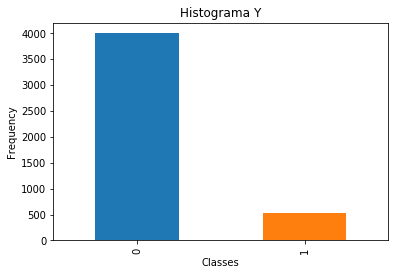

In [67]:
pd.value_counts(y).plot.bar()
plt.title('Histograma Y')
plt.xlabel('Classes')
plt.ylabel('Frequency')
y.value_counts()


In [68]:
index = ['age','housing', 'loan', 'job_blue-collar','job_entrepreneur', 'job_housemaid', 'job_management', 
         'job_retired','job_self-employed', 'job_services', 'job_student', 'job_technician','job_unemployed',
         'job_unknown', 'marital_married', 'marital_single','education_secondary', 'education_tertiary', 
         'education_unknown','day', 'month','contact_telephone', 'contact_unknown',  'balance',  'duration', 
         'campaign', 'pdays', 'previous','credit','poutcome_other','poutcome_success', 'poutcome_unknown']



X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_val.shape)
print("Number transactions y_test dataset: ", y_val.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

#sm = SMOTE(sampling_strategy=0.16,random_state=2)
sm = SMOTE(sampling_strategy='minority',random_state=2)

X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

X = X_train_res
Y = y_train_res

Number transactions X_train dataset:  (3616, 33)
Number transactions y_train dataset:  (3616,)
Number transactions X_test dataset:  (905, 33)
Number transactions y_test dataset:  (905,)
Before OverSampling, counts of label '1': 409
Before OverSampling, counts of label '0': 3207 

After OverSampling, the shape of train_X: (6414, 33)
After OverSampling, the shape of train_y: (6414,) 

After OverSampling, counts of label '1': 3207
After OverSampling, counts of label '0': 3207


In [69]:
from sklearn.metrics import recall_score
def measure_train(classifier):
    
    cv_results = pd.DataFrame(classifier.cv_results_)[['param_n_neighbors', 'mean_train_score','std_train_score','mean_test_score','std_test_score','mean_score_time']]
  
    print(cv_results)    
    y_pred = classifier.predict(X_train)
    matrix = confusion_matrix(y_train, y_pred)    
   # print('Recall manual'+ str(recall(matrix)))
    #print('Recall auto '+ str(recall_score(y_train, y_pred)))
    error = ErrorClass(y_train, y_pred) 
    print('Error de entrenamiento = ' + str(error))
    print('Mejor parámetro: '+str(classifier.best_params_))
    
def measure_val(classifier):
    
    y_pred = classifier.predict(X_val)
    print (confusion_matrix(y_val, y_pred))
    error = ErrorClass(y_val,y_pred) 
    print('Error de evaluación final = ' + str(error))

def measure_scoring(classifier):
    cv_results = pd.DataFrame(classifier.cv_results_)[['param_n_neighbors','mean_test_Error','mean_test_AUC','mean_train_Error','mean_train_AUC']]
    y_pred = classifier.predict(X_train)
    error = ErrorClass(y_train, y_pred) 
    print('Error de entrenamiento = ' + str(error))
    print(cv_results)

def measure_val_scoring(classifier):
    
    params = classifier.best_params_
    score = classifier.best_score_
    print ('\n Mejor parámetro '+str(params) + ' mejor valor:'+str(score))
    y_pred = classifier.predict(X_val)
    error = ErrorClass(y_pred,y_val) 
    print('Error de evaluación final = ' + str(error))
    
    
    #Para calcular el error en los problemas de clasificación
def ErrorClass(Y,Y_lest):
    error = 1 - np.sum(Y_lest == Y)/len(Y)    
    return error

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def recall(matrix):
    return (matrix[0,0]/(matrix[0,0]+matrix(1,0)))

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}


## Naïve Bayes

In [70]:
def naiveBayes(X, Y, cv=4, scoring=make_scorer(ErrorClass), refit='AUC'):
    
    parameters = {}
    
    scaler = preprocessing.StandardScaler().fit(X)
    X_norm = scaler.transform(X)
    # creamos el clasificador
    gnb = GaussianNB()
    classifier = GridSearchCV(gnb, parameters, cv=cv, scoring=scoring, refit=refit)
    classifier.fit(X_norm, Y)
    
    return classifier

def naiveBayes2(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred)) 
    return y_pred, y_pred_prob

def print_scores(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

## K vecinos más cercanos

In [71]:
def kNN(neighbors=1):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    Error = np.zeros(Folds)
    Error_eval = np.zeros(Folds)
    j = 0
   
    
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:].astype(float)
        Ytrain = Y[train].astype(float)
        Xtest = X[test,:].astype(float)
        Ytest = Y[test].astype(float)
        
        #Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        
        # creamos el clasificador
        classifier = KNeighborsClassifier(n_neighbors=neighbors)  
        classifier.fit(Xtrain, Ytrain)
        
        y_est = classifier.predict(Xtrain)
        
        y_pred = classifier.predict(Xtest)
        
        y_val_pred = classifier.predict(X_val)
        
        Error_eval[j] = ErrorClass(y_val_pred, y_val)
        
        Error[j] = ErrorClass(y_pred,Ytest)
        
        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(y_est.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(y_pred.ravel() == Ytest.ravel())
        j += 1
        
       
              
    print('Número vecinos: '+ str(neighbors))    
    print('Eficiencia durante el entrenamiento = ' + str(np.mean(EficienciaTrain)) + '+-' + str(np.std(EficienciaTrain)))
    print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))
    print('Error durante la validación = ' + str(np.mean(Error)) + '+-' + str(np.std(Error)))
    print('Error de evalución final = ' + str(np.mean(Error_eval)) + '+-' + str(np.std(Error_eval)))

In [72]:
def KNN(X, Y, neighbors=[5,10], cv=4, scoring=make_scorer(ErrorClass), refit='AUC'):
    
    parameters = {
    'n_neighbors': neighbors}
    
    scaler = preprocessing.StandardScaler().fit(X)
    X_norm = scaler.transform(X)
    # creamos el clasificador
    knn = KNeighborsClassifier()
    classifier = GridSearchCV(knn, parameters, cv=cv, scoring=scoring, refit=refit)
    classifier.fit(X_norm, Y)
    
    return classifier
  

In [73]:
def train_KNN(X, Y, neighbors=[5,10], cv=4):
    
    parameters = {
    'n_neighbors': neighbors}
    
    scaler = preprocessing.StandardScaler().fit(X)
    X_norm = scaler.transform(X)
    # creamos el clasificador
    knn = KNeighborsClassifier()
    classifier = GridSearchCV(knn, parameters, cv=cv)
    classifier.fit(X_norm, Y)
    
    
    return classifier

## Redes Neuronales Artificiales

In [74]:
#Mean Absolute Percentage Error para los problemas de regresión
def MAPE(Y_est,Y):
    N = np.size(Y)
    mape = np.sum(abs((Y_est.reshape(N,1) - Y.reshape(N,1))/Y.reshape(N,1)))/N
    return mape

def neuralNetwork(hidden=(28,)):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:].astype(float)
        Ytrain = Y[train].astype(float)
        Xtest = X[test,:].astype(float)
        Ytest = Y[test].astype(float)

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = preprocessing.scale(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        mlp = MLPClassifier(activation='tanh', hidden_layer_sizes=hidden, max_iter=500 )
        mlp.fit(Xtrain,Ytrain)

        #Validación con las muestras de entrenamiento
        Ytrain_pred = mlp.predict(Xtrain)

        #Validación con las muestras de test    
        Yest = mlp.predict(Xtest)

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred == Ytrain)
        EficienciaVal[j] = np.mean(Yest == Ytest)
        j += 1
    
    mean = round(np.mean(EficienciaTrain),5)
    std = round(np.std(EficienciaTrain),5)
    
    meanVal = round(np.mean(EficienciaVal),5)
    stdVal = round(np.std(EficienciaVal),5)
    
    return mean,std,meanVal,stdVal

mean,std,meanVal,stdVal = neuralNetwork()
print('Eficiencia durante el entrenamiento = ' + str(mean) + '+-' + str(std))
print('Eficiencia durante la validación = ' + str(np.mean(meanVal)) + '+-' + str(np.std(stdVal)))

Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.51481+-0.0


## Random Forest

In [75]:
def randomForest(num_tree=5, max_var=None):
    #Validamos el modelo
    Folds = 4
    #random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = sc.stats.stats.zscore(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        model = RandomForestClassifier(n_estimators = num_tree, max_features = max_var)
        model.fit(X=Xtrain, y=Ytrain)

        #Validación
        Ytrain_pred = model.predict(Xtrain)#Use el modelo previamente entrenado para hacer predicciones con las mismas muestras de entrenamiento
        Yest =  model.predict(Xtest)#Use el modelo previamente entrenado para hacer predicciones con las muestras de test

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(Yest.ravel() == Ytest.ravel())
        j += 1

    mean = round(np.mean(EficienciaTrain),4)
    std = round(np.std(EficienciaTrain),4)
    
    meanVal = round(np.mean(EficienciaVal),4)
    stdVal = round(np.std(EficienciaVal),4)
    
    return (mean, std, meanVal, stdVal)

# entrenamiento de varios modelos
num_trees = [1,2,3,4,5,10,20,50,100]
var_per_nodes = [1,2,3,4,5,10,15,20]
nums = np.zeros(len(num_trees) * len(var_per_nodes))
vars_per_nodes = np.zeros(len(num_trees) * len(var_per_nodes))
efi_val = np.zeros(len(num_trees) * len(var_per_nodes))
interval = np.zeros(len(num_trees) * len(var_per_nodes))

j = 0
for num in num_trees:
    for var in var_per_nodes:
        mean, std, meanVal, stdVal = randomForest(num,var)
        efi_val[j] = meanVal;
        interval[j] = stdVal;
        vars_per_nodes[j] = var
        nums[j] = num
        j+=1

### Tabla Random Forest

In [76]:
randn = np.random.randn
df_types = pd.DataFrame({
    'Numero de arboles' : pd.Series(nums), 
    'Variables analizadas por nodo' : pd.Series(vars_per_nodes)})
df_types["Eficiencia en validacion"] = efi_val
df_types["Intervalo de confianza"] = interval
df_types['Variables analizadas por nodo'] = vars_per_nodes
df_types.set_index(['Numero de arboles','Variables analizadas por nodo'], inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget.get_changed_df()

Eficiencia en validacion  \
Numero de arboles Variables analizadas por nodo                             
1.0               1.0                                              0.5383   
                  2.0                                              0.5337   
                  3.0                                              0.4941   
                  4.0                                              0.5000   
                  5.0                                              0.5000   
                  10.0                                             0.5000   
                  15.0                                             0.5000   
                  20.0                                             0.5000   
2.0               1.0                                              0.4889   
                  2.0                                              0.5008   
                  3.0                                              0.5000   
                  4.0                                              0.5026   
                  5.0                                              0.5000   
                  10.0                                             0.5000   
                  15.0                                             0.5000   
                  20.0                                             0.5000   
3.0               1.0                                              0.4998   
                  2.0                                              0.4980   
                  3.0                                              0.4995   
                  4.0                                              0.5000   
                  5.0                                              0.5000   
                  10.0                                             0.5000   
                  15.0                                             0.5000   
                  20.0                                             0.5000   
4.0               1.0                                              0.4997   
                  2.0                                              0.4853   
                  3.0                                              0.5009   
                  4.0                                              0.5000   
                  5.0                                              0.5000   
                  10.0                                             0.5000   
...                                                                   ...   
10.0              3.0                                              0.5000   
                  4.0                                              0.5000   
                  5.0                                              0.5000   
                  10.0                                             0.5000   
                  15.0                                             0.5000   
                  20.0                                             0.5000   
20.0              1.0                                              0.4989   
                  2.0                                              0.4995   
                  3.0                                              0.5000   
                  4.0                                              0.5000   
                  5.0                                              0.5000   
                  10.0                                             0.5000   
                  15.0                                             0.5000   
                  20.0                                             0.5000   
50.0              1.0                                              0.5221   
                  2.0                                              0.5000   
                  3.0                                              0.5000   
                  4.0                                              0.5000   
                  5.0                                              0.5000   
                  10.0                       

## Máquinas de Soporte Vectorial con kernel lineal y con kernel RBF.

In [60]:
# lineal kernel and rbf kernel
def SVM(kernel='linear', c=0.001 ,gamma=0):

    if gamma is 0:
        gamma = 'auto'
        
    #Validamos el modelo
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    percentVectors = np.zeros(Folds)
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:].astype(float)
        Ytrain = Y[train].astype(float)
        Xtest = X[test,:].astype(float)
        Ytest = Y[test].astype(float)

        #Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        modelo = SVC(C= c,kernel=kernel,gamma=gamma,  decision_function_shape='ovo')
        modelo.fit(Xtrain, Ytrain)
        
        #Calculamos el porcentaje de vector de soporte
        percentVectors[j] = (len(modelo.support_vectors_)/len(Xtrain))

        #Validación
        Ytrain_pred = modelo.predict(Xtrain)
        Yest = modelo.predict(Xtest)

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(Yest.ravel() == Ytest.ravel())
        j += 1

        
    #print('Eficiencia durante el entrenamiento = ' + str(np.mean(EficienciaTrain)) + '+-' + str(np.std(EficienciaTrain)))
    #print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))
    #print('% Vectore de soporte = ', modelo.n_support_.sum()/720)
    mean = round(np.mean(EficienciaVal),5)
    std = round(np.std(EficienciaVal),5)
    percent = round(percentVectors.sum()/4, 5)
    return mean,std,percent

#mean,std,percent = SVM(kernel='linear',c=1, gamma=0)

#print('Eficiencia durante el entrenamiento = ' + str(np.mean(mean)) + '+-' + str(np.std(std)))
#print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))
#print('% Vectore de soporte = ', percent)

kernels = ['lineal','lineal','lineal','lineal','lineal','lineal','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf']
cs = [0.001,0.01,0.1,1,10,100,0.001,0.001,0.001,0.01,0.01,0.01,0.1,0.1,0.1,1,1,1,10,10,10,100,100,100]
gammas = [0,0,0,0,0,0,0.01,0.1,1,0.01,0.1,1,0.01,0.1,1,0.01,0.1,1,0.01,0.1,1,0.01,0.1,1]
medias = np.zeros(len(kernels))
stds = np.zeros(len(kernels))
percents = np.zeros(len(kernels))

for i in range(0,len(kernels)):
    if kernels[i] is 'lineal':
        kernel = 'linear'
    elif kernels[i] is 'rbf':
        kernel =  'rbf'
    medias[i],stds[i],percents[i] = SVM(kernel=kernel, c=cs[i], gamma=gammas[i])

## Tabla SVM

In [81]:
import pandas as pd
import qgrid

df_types = pd.DataFrame({
    'Kernel' : pd.Series(kernels),
    'C' : pd.Series(cs),
    'gamma' : pd.Series(gammas)})
df_types["Eficiencia en validacion"] = medias
df_types["Intervalo de confianza"] = stds
df_types["% de Vectores de Soporte"] = percents*100
df_types.set_index(['Kernel','C','gamma'], inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget.get_changed_df()

Eficiencia en validacion  Intervalo de confianza  \
Kernel C       gamma                                                     
lineal 0.001   0.00                    1.00000                 0.00000   
       0.010   0.00                    1.00000                 0.00000   
       0.100   0.00                    1.00000                 0.00000   
       1.000   0.00                    1.00000                 0.00000   
       10.000  0.00                    1.00000                 0.00000   
       100.000 0.00                    1.00000                 0.00000   
rbf    0.001   0.01                    0.95262                 0.06444   
               0.10                    0.73543                 0.06313   
               1.00                    0.54132                 0.01192   
       0.010   0.01                    0.96322                 0.05832   
               0.10                    0.81510                 0.07487   
               1.00                    0.54132                 0.01192   
       0.100   0.01                    0.98784                 0.02070   
               0.10                    0.93578                 0.07820   
               1.00                    0.58295                 0.01971   
       1.000   0.01                    0.99517                 0.00837   
               0.10                    0.96649                 0.05660   
               1.00                    0.88324                 0.08383   
       10.000  0.01                    0.99610                 0.00675   
               0.10                    0.96743                 0.05498   
               1.00                    0.89025                 0.08627   
       100.000 0.01                    0.99610                 0.00675   
               0.10                    0.96743                 0.05498   
               1.00                    0.89025                 0.08627   

                      % de Vectores de Soporte  
Kernel C       gamma                            
lineal 0.001   0.00                     21.604  
       0.010   0.00                      3.264  
       0.100   0.00                      1.902  
       1.000   0.00                      1.731  
       10.000  0.00                      1.731  
       100.000 0.00                      1.731  
rbf    0.001   0.01                    100.000  
               0.10                    100.000  
               1.00                    100.000  
       0.010   0.01                     70.439  
               0.10                     80.698  
               1.00                    100.000  
       0.100   0.01                     20.538  
               0.10                     43.763  
               1.00                     98.971  
       1.000   0.01                      7.063  
               0.10                     32.138  
               1.00                     86.732  
       10.000  0.01                      5.504  
               0.10                     31.836  
               1.00                     85.869  
       100.000 0.01                      5.498  
               0.10                     31.836  
               1.00                     85.869

## Entrenamiento

In [77]:
X = X_train_res
Y = y_train_res

kNN(1)

Número vecinos: 1
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.9540178891099342+-0.053580010886694625
Error durante la validación = 0.045982110890065736+-0.053580010886694625
Error de evalución final = 0.1759668508287293+-0.08214551847885414


#### Naive Bayes

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
y_pred, y_pred_prob = naiveBayes2(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

train-set confusion matrix:
 [[22347    12]
 [    0  3577]]
test-set confusion matrix:
 [[9578    5]
 [   3 1530]]
recall score:  0.9980430528375733
precision score:  0.996742671009772
f1 score:  0.997392438070404
accuracy score:  0.9992803166606693
ROC AUC: 0.999795449364392


In [ ]:

neighbors=[1,3,5,10]

#def KNN(X, Y, neighbors=[5,10], cv=4, scoring=make_scorer(ErrorClass)):
skf = StratifiedKFold(n_splits=4, random_state=42)
#kNN()
print('Selección del modelo por eficiencia')
classifier = train_KNN(X,Y,neighbors, skf)

measure_train(classifier)
measure_val(classifier)

Selección del modelo por eficiencia


c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
print('La selección del modelo con AUC \n')
scoring = {'AUC': 'roc_auc', 'Error': make_scorer(ErrorClass)}
classifier_2 = KNN(X,Y, neighbors, skf, scoring, 'AUC')
measure_scoring(classifier_2)
measure_val_scoring(classifier_2)

In [215]:
def trainModel():
    
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = sc.stats.stats.zscore(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

### Tener en cuenta

In [63]:
df_bank['job'].describe()

count           4521
unique            12
top       management
freq             969
Name: job, dtype: object

In [73]:
df_bank[df_bank['pdays'] == -1].shape

(36954, 17)

In [ ]:
out = df_bank["y"]
out = out.replace("no", 0)
out = out.replace("yes", 1)
x = df_bank["education"]
y = df_bank["job"]

#_ = sns.swarmplot(x='duration', y='age', data=df_bank)
#plt.hist(y)
# Label the axes
plt.title('Age vs housing', fontsize=14)
plt.xlabel('Edad')
plt.ylabel('duration')
plt.scatter(x,y,c=out,cmap="Accent")
plt.show()

In [ ]:
sns.set(style="whitegrid")
ax = sns.swarmplot(x="housing", y="age", data=df_bank)

In [34]:

#print("Tipos datos", df_bank.dtypes)
df_bank[df_bank['poutcome'] != 'unknown']
df_success = df_bank[df_bank['y'] == 'yes']
df_no_success = df_bank[df_bank['y'] == 'no']

print("Muestras de exito ",df_success.shape, "Muestras de no éxito",df_no_success.shape)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

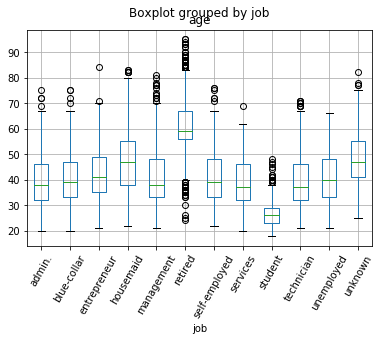

In [17]:
df_bank.boxplot('age','job',rot=60)
plt.show()